In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
import pandas as pd
import numpy as np
import random

In [21]:
from PIL import Image,ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

**Load Dataset**

In [22]:
train_dir="/content/drive/MyDrive/Brain TumarData/Training"
test_dir="/content/drive/MyDrive/Brain TumarData/Testing"

In [23]:
train_paths=[]
train_labels=[]

for  label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir,label)):
    train_paths.append(os.path.join(train_dir,label,image))
    train_labels.append(label)
train_paths,train_labels=shuffle(train_paths,train_labels)

In [24]:
test_paths=[]
test_labels=[]

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,image))
    test_labels.append(label)

test_paths,test_labels=shuffle(test_paths,test_labels)

**data visulize**

In [25]:
import matplotlib.pyplot as plt

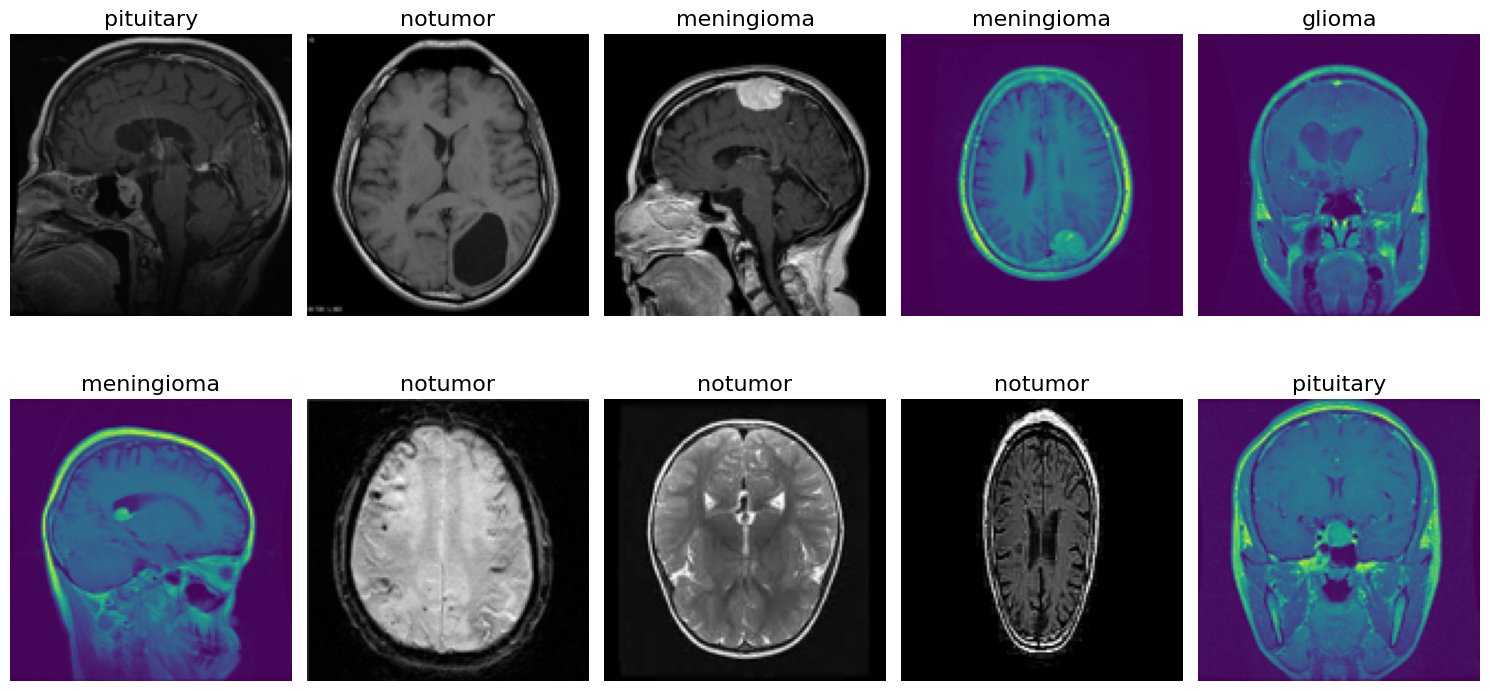

In [26]:
fig,ax=plt.subplots(2,5,figsize=(15,8))
for i,img_path in enumerate(train_paths[:10]):
  row=i//5
  col=i%5
  img=Image.open(img_path)
  img=img.resize((128,128))
  ax[row,col].imshow(img)
  ax[row,col].axis('off')
  ax[row,col].set_title(train_labels[i],fontsize=16)
plt.tight_layout()
plt.show()

**Image preprocessing**

In [27]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

**Model**

In [28]:
IMAGE_SIZE=128
base_model=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')


In [29]:
# for layers in base_model.layers:
#   layers.trainale=False
for layer in base_model.layers:
    layer.trainable = False

In [30]:
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [31]:
for i, layer in enumerate(base_model.layers):
    print(f"{i:3d} | {layer.name:25s} | Trainable: {layer.trainable}")


  0 | input_layer_2             | Trainable: False
  1 | block1_conv1              | Trainable: False
  2 | block1_conv2              | Trainable: False
  3 | block1_pool               | Trainable: False
  4 | block2_conv1              | Trainable: False
  5 | block2_conv2              | Trainable: False
  6 | block2_pool               | Trainable: False
  7 | block3_conv1              | Trainable: False
  8 | block3_conv2              | Trainable: False
  9 | block3_conv3              | Trainable: False
 10 | block3_pool               | Trainable: False
 11 | block4_conv1              | Trainable: False
 12 | block4_conv2              | Trainable: False
 13 | block4_conv3              | Trainable: False
 14 | block4_pool               | Trainable: False
 15 | block5_conv1              | Trainable: True
 16 | block5_conv2              | Trainable: True
 17 | block5_conv3              | Trainable: True
 18 | block5_pool               | Trainable: False


**Final Model**

In [32]:
model=Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))


In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [34]:
model.compile(optimizer=Adam(0.0001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
batch_size=20
step=len(train_paths)//batch_size

**Train Model**

In [35]:
val_step = len(test_paths) // batch_size
val_step

65

In [36]:
history=model.fit(datagen(
    train_paths,train_labels,batch_size,epochs=5
),steps_per_epoch=step,epochs=5)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1243s 4s/step - loss: 0.6176 - sparse_categorical_accuracy: 0.7527
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1226s 4s/step - loss: 0.2384 - sparse_categorical_accuracy: 0.9157
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1221s 4s/step - loss: 0.1619 - sparse_categorical_accuracy: 0.9419
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1222s 4s/step - loss: 0.1371 - sparse_categorical_accuracy: 0.9488
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1223s 4s/step - loss: 0.1005 - sparse_categorical_accuracy: 0.9636


**Classification Report**

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       300
           1       0.90      0.89      0.90       306
           2       0.91      0.95      0.93       300
           3       1.00      0.96      0.98       405

    accuracy                           0.95      1311
   macro avg       0.94      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



Confusion Matrix:
[[297   2   1   0]
 [  8 273  25   0]
 [  2  14 284   0]
 [  1  14   1 389]]


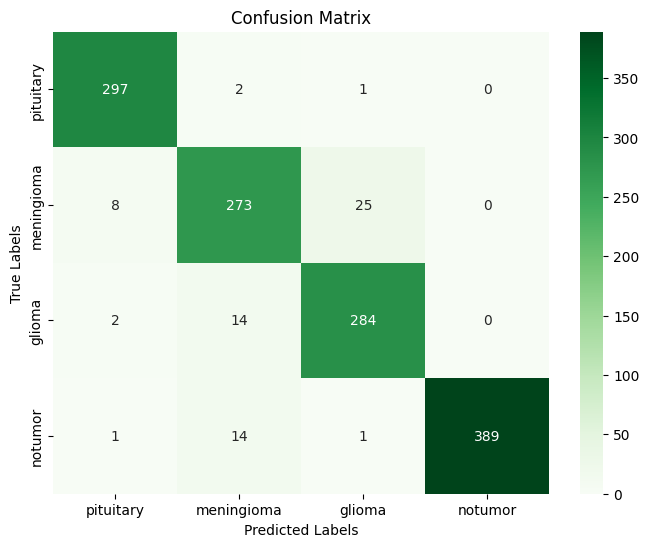

In [44]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

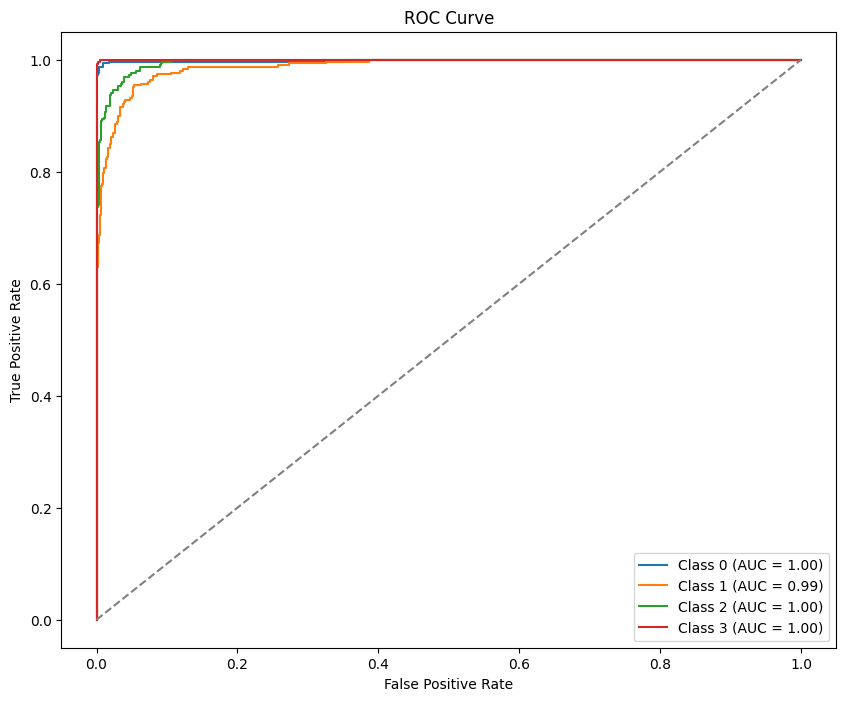

In [53]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

**Save Model**

In [38]:
model.save('model1.h5')

**MRI Detection System**

Load MOdel

In [46]:
from tensorflow.keras.models import load_model
model = load_model('model1.h5')

In [59]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'meningioma', 'glioma', 'notumor']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

In [58]:
for i in os.listdir(train_dir):
  print(i)

pituitary
meningioma
glioma
notumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


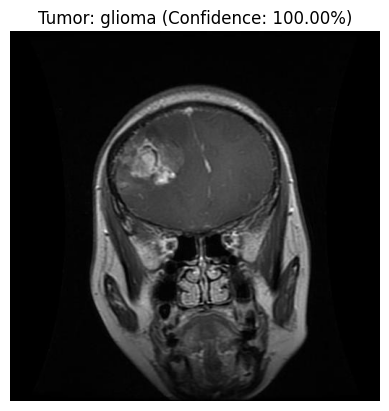

In [60]:
# Example usage
image_path = '/content/drive/MyDrive/Brain TumarData/Training/glioma/Tr-glTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


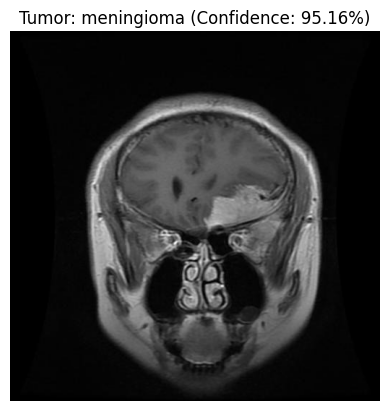

In [61]:
image_path = '/content/drive/MyDrive/Brain TumarData/Training/meningioma/Tr-meTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)